## 1. DBSCAN

### a. Data Prep

In [7]:
# import pandas and pull file entertainment_clean.csv
import pandas as pd
entertainment_clean = pd.read_csv('../Data/entertainment_clean.csv')

In [11]:
# make a copy
model = entertainment_clean.copy()
model.head()

,name,books,tv_shows,video_games
0,Aaliyah,0.5,4.6,4.9
1,Abigail,0.0,4.5,4.8
2,Addison,0.5,4.5,5.0
3,Adeline,3.5,4.5,6.6
4,Alana,2.8,3.8,5.6


In [13]:
# keep only the numeric columns
df = model.iloc[:,1:]
df.head()

,books,tv_shows,video_games
0,0.5,4.6,4.9
1,0.0,4.5,4.8
2,0.5,4.5,5.0
3,3.5,4.5,6.6
4,2.8,3.8,5.6


In [15]:
# note the shape of the data
df.shape

(150, 3)

In [17]:
# dbscan function to find a good eps + min_samples combo (I keep it as a script, easy to use copy and paste)
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def tune_dbscan(data):

    results = []

    # define a range of eps and min_samples values to loop through
    eps_values = np.arange(.1, 2, .1)
    min_samples_values = np.arange(2, 10, 1)

    # loop through the combinations of eps and min_samples
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan.fit(data)
            labels = dbscan.labels_

            # count the number of clusters (excluding noise points labeled as -1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            # count the number of noise points (labeled as -1)
            n_noise = list(labels).count(-1)

            # calculate the silhouette score (excluding noise points)
            if n_clusters > 1:  # silhouette score requires at least 2 clusters
                silhouette = silhouette_score(data, labels, metric='euclidean', sample_size=None)
            else:
                silhouette = None

            results.append([eps, min_samples, n_clusters, n_noise, silhouette])

    # put the results in a dataframe
    dbscan_results = pd.DataFrame(results, columns=["Eps", "Min Samples", "Number of Clusters",
                                                    "Number of Noise Points", "Silhouette Score"])
    return dbscan_results

In [21]:
# view the results on the original data, we take 'tune_dbscan' from def 
dbscan_results = tune_dbscan(df)
dbscan_results.head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
0,0.1,2,12,124,-0.438782
1,0.1,3,2,144,-0.483479
2,0.1,4,0,150,NaN
3,0.1,5,0,150,NaN
4,0.1,6,0,150,NaN


In [25]:
# top silhouette scores
dbscan_results.sort_values('Silhouette Score',ascending=False).head()

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
127,1.6,9,2,0,0.628673
109,1.4,7,2,0,0.628673
107,1.4,5,2,0,0.628673
106,1.4,4,2,0,0.628673
105,1.4,3,2,0,0.628673


In [27]:
# return one eps + min_samples combo for each silhouette score
(dbscan_results.sort_values('Silhouette Score',ascending=False).groupby('Silhouette Score').head(1)).head(10)

,Eps,Min Samples,Number of Clusters,Number of Noise Points,Silhouette Score
127,1.6,9,2,0,0.628673
76,1.0,6,2,2,0.550831
79,1.0,9,2,3,0.528540
72,1.0,2,2,1,0.515323
57,0.8,3,2,4,0.497686
62,0.8,8,2,5,0.482653
43,0.6,5,2,12,0.480329
52,0.7,6,2,9,0.476795
41,0.6,3,2,11,0.476287
63,0.8,9,2,6,0.471959


We choose data with high Silhouette Score, from this we have 'Eps' and 'Min Samples' to tune our DBSCAN model

In [33]:
# fit a dbscan model, # we choose eps = 1.0, min samples = 6 because we have 2 anomalies (our goal is finding anomalies.
# if you want to find more anomalies, base on our dbscan_results, you can find Number of Noise Points (depends on your goal)
dbscan = DBSCAN(eps=1.0, min_samples=6)
dbscan.fit(df)

DBSCAN(eps=1.0, min_samples=6)

In [35]:
# view the cluster assignments
dbscan.labels_

array([ 0,  0,  0,  1,  1,  1,  1,  1,  0,  1,  1,  0,  0,  0,  0,  0,  1,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  0,  1,  1,  1,  0,  0,  1,  1,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
        1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  0,
        1,  1,  1,  1,  0,  1,  0,  0, -1,  1,  0,  0,  0,  1,  1,  0,  1,
        1,  1,  1,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,
        1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  1,  0,  0],
      dtype=int64)

### b. Visualize the Anomalies

In [37]:
# view our dataset
df.head()

,books,tv_shows,video_games
0,0.5,4.6,4.9
1,0.0,4.5,4.8
2,0.5,4.5,5.0
3,3.5,4.5,6.6
4,2.8,3.8,5.6


In [39]:
# view the anomaly labels from dbscan
df['anomaly_dbscan'] = dbscan.labels_
df.head()

,books,tv_shows,video_games,anomaly_dbscan
0,0.5,4.6,4.9,0
1,0.0,4.5,4.8,0
2,0.5,4.5,5.0,0
3,3.5,4.5,6.6,1
4,2.8,3.8,5.6,1


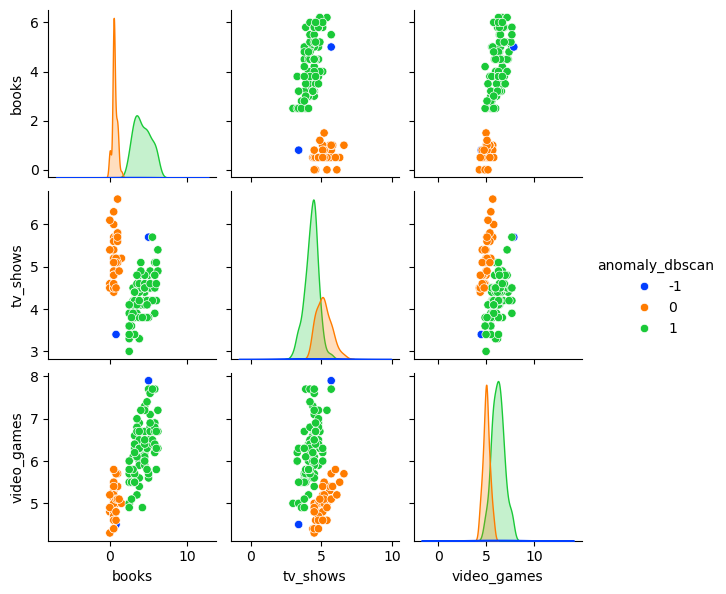

In [43]:
# view specific anomalies by pair plot
import seaborn as sns
sns.pairplot(df,hue='anomaly_dbscan',palette='bright',height=2)

From the pairplot, you can see I choose 2 anomalies from dbscan_results. I will show anomalies below

In [ ]:
# Watch anomalies data from filter

In [50]:
df[df['anomaly_dbscan']==-1]

,books,tv_shows,video_games,anomaly_dbscan
37,0.8,3.4,4.5,-1
110,5.0,5.7,7.9,-1


In [ ]:
# combine to our dataset, we can see name

In [56]:
data = pd.concat([model,df],axis=1)

In [58]:
data[data['anomaly_dbscan']==-1]

,name,books,tv_shows,video_games,books,tv_shows,video_games,anomaly_dbscan
37,Elena,0.8,3.4,4.5,0.8,3.4,4.5,-1
110,Octavia,5.0,5.7,7.9,5.0,5.7,7.9,-1
